# Workflow Notebook
This notebook is intended to present models which are loaded from other files as well as the results they allow us to reach.

## Global variables and imports

In [40]:
import csv
import gensim
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from gensim.models import Word2Vec
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import sequence, text
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [41]:
NB_CATEGORIES = 52
PADDING = 100

dataFolder = './challenge_data'
xPath = os.path.join(dataFolder, 'input_train.csv')
yPath = os.path.join(
    dataFolder, 'challenge_output_data_training_file_predict_the_expected_answer.csv')

Here, one defines the generic workflow which will be used after. In particular, the chronology we chose here is the following:
* create model
* preprocess signal (tokenize sentences, etc)
* train model
* predict on test data

In [42]:
class CustomModel():
    '''Generic workflow class.'''

    def __init__(self, **kwargs):
        self.verbose = kwargs.get('verbose', False)

        self.nbCategories = kwargs['nbCategories']
        self.paddingLength = PADDING
        self.maxNumberWords = (1e5)
        self.trainable = kwargs.get('trainable', False)

        self.tokenizer = text.Tokenizer(
            num_words=self.maxNumberWords,
            filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
            split=" "
        )

    def preprocess(self, x):
        '''Turns sentences into padded word sequences.'''

        self.tokenizer.fit_on_texts(x)
        sequences = self.tokenizer.texts_to_sequences(x)
        sequences = sequence.pad_sequences(sequences, self.paddingLength)

        return sequences

    def preprocessLabels(self, labels):
        return to_categorical(labels, num_classes=self.nbCategories)

    def train(self, x, y, epochs= 10, batch_size=32, validation_data=None,
              callback=False):
        if callback == True:
            filepath= 'models_checkpoints/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
            checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                                         verbose=1, save_best_only=True, mode='max')
            callbacks_list = [checkpoint]

            self.model.fit(x, y, shuffle='batch', epochs=epochs,
                           batch_size=batch_size, validation_data=validation_data,
                           callbacks=callbacks_list)
        else:
            self.model.fit(x, y, shuffle='batch', epochs=epochs,
                           batch_size=batch_size, validation_data=validation_data)

    def evaluate(self, x, y):
        return self.model.evaluate(x, y)

    def predict(self, x):
        return self.model.predict(x)

## Customize generic workflow

### Preprocessing

#### Spelling corrections

In [43]:
correctionsPath = os.path.join(dataFolder, 'corrections.csv')

In [44]:
class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def spellingCorrection(self, x, correct_dict={}, verbose=False):
        corrected_x = []
        for w in x.split():
            if w in correct_dict.keys():
                w_corrected = corrected_dict[w]
                if verbose == True:
                    print('Correction of ' + w + ' in ' + w_corrected)
                w = w_corrected
            corrected_x.append(w)
        return ' '.join(corrected_x)

#### Differenciate medics from other words
We here use a list of medication names to distinguish better between common words and specialized ones.

In [45]:
MEDICAMENTS = []

with open(os.path.join(dataFolder, 'medicList.txt')) as f:
    for line in f:
        MEDICAMENTS.append(line.lower().rstrip())

print('Liste de médicaments regroupant les libéllés ATC et les'
      'dénominations de spécialité, de taille: {}'.format(len(MEDICAMENTS)))
print('Sample of medicament names: ', MEDICAMENTS[:10])

Liste de médicaments regroupant les libéllés ATC et lesdénominations de spécialité, de taille: 8390
Sample of medicament names:  ['a 313 200  pour cent', 'a 313 50 000 u.i', 'abacavir', 'abacavir/lamivudine', 'abacavir/lamivudine pharma', 'abacavir/lamivudine pharos', 'abamipharm', 'abboticine', 'abelcet', 'abstral']


In [46]:
'ibuprofene' in MEDICAMENTS

True

In [47]:
class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.medicaments = kwargs['medicaments']

### Mathematical Model
Here, we implement several models (CNN, RNN, etc) with different shapes.

In [236]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import Input, Conv1D, Dense, Dropout, GlobalMaxPooling1D

class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def buildCNN1D(self, embedding, drop_rate=0.3, nb_filters=128,
                   filter_size=4, padding = PADDING):
        self.embedding = embedding

        my_input = keras.Input(shape=(self.paddingLength,), name= 'input')

        embedding = (Embedding(input_dim=self.embedding.shape[0],
                               output_dim=self.embedding.shape[1],
                               weights=[self.embedding],
                               input_length=self.paddingLength,
                               trainable=self.trainable,
                               name='embedding'))(my_input)
#         embedding_dropped = Dropout(drop_rate, name='drop0')(embedding)

        conv1 = Conv1D(nb_filters, filter_size,
                       activation='relu', name='conv1')(embedding)
        pooled1 = GlobalMaxPooling1D(name='pool1')(conv1)
        dropped1 = Dropout(drop_rate, name='drop1')(pooled1)
        dense1 = Dense(self.nbCategories, activation = 'relu', name = 'dense1')(dropped1)
        
#         prob = Dense(self.nbCategories, activation='softmax', name='softmax')(dense1)
        
        self.model = Model(my_input, dense1)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

In [237]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import LSTM, Embedding, Dropout


class CustomModel(CustomModel):
    '''Extended CustomModel'''
    
    def buildLSTM(self, embedding, drop_rate=0.3, nb_filters=128, filter_size=3):
        self.embedding = embedding

        my_input = Input(shape=(self.paddingLength,), name= 'input')

        embedding = Embedding(input_length=self.paddingLength,
                                input_dim=self.embedding.shape[0],
                                output_dim=self.embedding.shape[1],
                                weights=[self.embedding],
                                trainable=self.trainable,
                                name='embedding')(my_input)

        embedding_dropped = Dropout(drop_rate, name='drop0')(embedding)
        lstm1 = LSTM(100, name = 'lstm1', dropout= drop_rate,
                     recurrent_dropout= drop_rate)(embedding_dropped)
        dense1 = Dense(self.nbCategories, activation = 'relu', name = 'dense1')(lstm1)
        prob = Dense(self.nbCategories, activation='softmax', name='softmax')(dense1)

        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

#### 2D convnet for text classification: 
Inspired from : https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [238]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import MaxPooling1D, LSTM, Conv1D


class CustomModel(CustomModel):
    '''Extended CustomModel'''
    
    def buildLSTM_CNN(self, embedding, drop_rate=0.3, nb_filters=128, filter_size=3):
        self.embedding = embedding

        my_input = Input(shape=(self.paddingLength,), name= 'input')

        embedding = Embedding(input_length=self.paddingLength,
                                input_dim=self.embedding.shape[0],
                                output_dim=self.embedding.shape[1],
                                weights=[self.embedding],
                                trainable=self.trainable,
                                name='embedding')(my_input)

        embedding_dropped = Dropout(drop_rate, name='drop0')(embedding)
        conv1 = Conv1D(nb_filters, filter_size, activation='relu',
                       name='conv1', padding='same')(embedding_dropped)
        pooled1 = MaxPooling1D(pool_size = 2, name = 'pool1')(conv1)
        dropped1 = Dropout(drop_rate, name = 'drop1')(pooled1)
        lstm1 = LSTM(100, name = 'lstm1',
                     dropout= drop_rate, recurrent_dropout= drop_rate)(dropped1)
        prob = Dense(self.nbCategories,
                     activation='softmax', name='dense1')(lstm1)

        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

In [239]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import (Input, Conv2D, Dense, Dropout,
                          MaxPooling2D, Flatten, Concatenate, Reshape)


class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def buildCNN2D(self, embedding, drop_rate=0.3, nb_filters=128, filter_size=[3, 5, 8],
                   padding=PADDING):
        if np.isscalar(filter_size):
            filter_size = [3, 5, 8]
            print("WARNING: You have to enter a list for the different\
            filter sizes, we modified directly to: {}".format(filter_size))
        
        self.embedding = embedding

        my_input = Input(shape=(self.paddingLength, ), name= 'input')

        embedding = Embedding(input_dim=self.embedding.shape[0],
                               output_dim=self.embedding.shape[1],
                               weights=[self.embedding],
                               input_length=self.paddingLength,
                               trainable=self.trainable,
                               name='embedding')(my_input)
        embedding = Reshape((padding, self.embedding.shape[1], 1))(embedding)
        embedding_dropped = Dropout(drop_rate, name='drop0')(embedding)
        
        # we concatenate 3 filter sizes
        conv0 = Conv2D(nb_filters, (filter_size[0], self.embedding.shape[1]),
                       activation='relu', name='conv0', padding='valid')(embedding_dropped)
        pooled0 = MaxPooling2D(pool_size=(padding - filter_size[0] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool0')(conv0)
        
        conv1 = Conv2D(nb_filters, (filter_size[1], self.embedding.shape[1]),
                       activation='relu', name='conv1', padding='valid')(embedding_dropped)
        pooled1 = MaxPooling2D(pool_size = (padding - filter_size[1] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool1')(conv1)
        
        conv2 = Conv2D(nb_filters, (filter_size[2], self.embedding.shape[1]),
                       activation='relu', name='conv2', padding='valid')(embedding_dropped)
        pooled2 = MaxPooling2D(pool_size = (padding - filter_size[2] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool2')(conv2)
        
        concatenated = Concatenate(axis = 1)([pooled0, pooled1, pooled2])
        flattened = keras.layers.Flatten()(concatenated)
        dropped1 = Dropout(drop_rate, name='drop1')(flattened)  
        prob = Dense(self.nbCategories, activation='softmax', name='dense2')(dropped1)

        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

## Model training

In [240]:
# Model variables
TRAINABLE = False # Training the embedding can lead to overfitting
PRE_TRAINED_DIM = 300 # Size of the pretrained embedding used here
REDUCED_DIM = 100

In [241]:
# Model instance creation
model = CustomModel(nbCategories=NB_CATEGORIES, trainable=TRAINABLE, medicaments=MEDICAMENTS)

# Loading, parsing and spliting training and testing data
x = pd.read_csv(xPath, delimiter=';', usecols=[1]).values.ravel()
y = pd.read_csv(yPath, delimiter=';', usecols=[1]).values.ravel()

In [242]:
# Correct spelling mistakes
corrected_dict = {}
for key, val in csv.reader(open(correctionsPath)):
    corrected_dict[key] = val
for i, s in enumerate(x):
    x[i] = model.spellingCorrection(s, corrected_dict, verbose=False)

In [243]:
# Print some info about our vocabulary
model.preprocess(x)
x_vocab  = list(model.tokenizer.word_index.keys())
print('Vocabulary size: ', len(x_vocab))

Vocabulary size:  9341


In [245]:
from unidecode import unidecode

In [20]:
# Loading and using pretrained embedding (fasttext or EMEA)
embeddingPath = '../wiki.fr.vec'
# embeddingPath = '../word_embeddings/retrained_fr.vec'

pre_trained_wv = gensim.models.KeyedVectors.load_word2vec_format(embeddingPath,
                                                                 binary=False)

# We use an embedding size of len(x_vocab) + 1 because the 0 is used for the padding
embeddings = np.zeros((len(x_vocab) + 1 , PRE_TRAINED_DIM))
not_in_pretrained = []
detected_medic = []

for word, idx in model.tokenizer.word_index.items():
    if word not in pre_trained_wv.vocab:
        unaccented = unidecode(word)
        if word in model.medicaments:
            vec = pre_trained_wv['médicament']
            detected_medic.append(word)
        else:
            vec = np.zeros(PRE_TRAINED_DIM)
            not_in_pretrained.append(word)
    else:
        vec = pre_trained_wv[word]

    # word_to_index is 1-based! the 0-th row, used for padding, stays at zero
    embeddings[idx,] = vec

print('---------- Embedding Created ----------')
print('Number of words in corpus that do not appear in '
      'pretrained Fasttext: ', len(not_in_pretrained))

---------- Embedding Created ----------
Number of words in corpus that do not appear in pretrained Fasttext:  1340


In [247]:
len(detected_medic)

363

In [248]:
from sklearn.decomposition import PCA
# reduce embedding dimension
pca = PCA(n_components=REDUCED_DIM)
reduced_embeddings = pca.fit_transform(embeddings)

In [249]:
# saving the embedding for convenience
#np.save('challenge_data/fasttext_voc_not_corrected.npy', embeddings)
#np.save('challenge_data/fasttext_emb.npy', embeddings)
# np.save('challenge_data/fasttext_retrained.npy', embeddings)
#embeddings = np.load('challenge_data/fasttext_emb.npy')
#embeddings = np.load('challenge_data/fasttext_voc_not_corrected.npy')
# embeddings = np.load('challenge_data/fasttext_retrained.npy')

In [250]:
# Model parameters among (drop_rate=0.3, nb_filters=32, filter_size=3)
DROP_RATE = 0.3
NB_FILTERS = 1024
FILTER_SIZE = 3
#FILTERS_SIZES = []
# Build our model
model.buildCNN1D(reduced_embeddings, drop_rate=DROP_RATE, nb_filters=NB_FILTERS,
                    filter_size=FILTER_SIZE)
model.model.summary()

print('Total number of model parameters:', model.model.count_params())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 100)               0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          934200    
_________________________________________________________________
conv1 (Conv1D)               (None, 98, 1024)          308224    
_________________________________________________________________
pool1 (GlobalMaxPooling1D)   (None, 1024)              0         
_________________________________________________________________
drop1 (Dropout)              (None, 1024)              0         
_________________________________________________________________
dense1 (Dense)               (None, 52)                53300     
Total params: 1,295,724
Trainable params: 361,524
Non-trainable params: 934,200
______________________________________________________________

In [251]:
# Preprocess input data and labels before training
y = model.preprocessLabels(y)
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

xTrain = model.preprocess(xTrain)
xTest = model.preprocess(xTest)

In [252]:
# Training
BATCH_SIZE = 32
EPOCHS = 10

model.train(xTrain, yTrain, epochs=EPOCHS, batch_size= BATCH_SIZE,
            validation_data=(xTest, yTest))

Train on 6422 samples, validate on 1606 samples
Epoch 1/10
6422/6422 [==============================] - 17s 3ms/step - loss: 8.4783 - acc: 0.2199 - val_loss: 8.1252 - val_acc: 0.2360
Epoch 2/10
6422/6422 [==============================] - 20s 3ms/step - loss: 8.2376 - acc: 0.2414 - val_loss: 8.0307 - val_acc: 0.2590
Epoch 3/10
6422/6422 [==============================] - 20s 3ms/step - loss: 8.1263 - acc: 0.2638 - val_loss: 8.2292 - val_acc: 0.2821
Epoch 4/10
6422/6422 [==============================] - 24s 4ms/step - loss: 8.0534 - acc: 0.2801 - val_loss: 7.9477 - val_acc: 0.2933
Epoch 5/10
6422/6422 [==============================] - 22s 3ms/step - loss: 8.0854 - acc: 0.2182 - val_loss: 8.0427 - val_acc: 0.2790
Epoch 6/10
6422/6422 [==============================] - 22s 3ms/step - loss: 8.0199 - acc: 0.2923 - val_loss: 8.6888 - val_acc: 0.2902
Epoch 7/10
6422/6422 [==============================] - 21s 3ms/step - loss: 7.9814 - acc: 0.3135 - val_loss: 8.4252 - val_acc: 0.2883
Epoch 8

## Model Evaluation

In [253]:
loss = model.evaluate(xTest, yTest)

prediction = model.predict(xTest)
predictionCategories = np.argmax(prediction, axis=1)
yTestCategories = np.argmax(yTest, axis=1)
accuracy = 100 * sum([predictionCategories[i] == yTestCategories[i]
                      for i in range(len(yTestCategories))]) / len(yTestCategories)

print('Accuracy: {:.2f} %\nLoss: {}'.format(accuracy, str(loss)))

1606/1606 [==============================] - 1s 539us/step
Accuracy: 30.20 %
Loss: [8.893423225336324, 0.30199252801992527]


Plot accuracy per category.

In [254]:
import collections

In [255]:
yPosition = np.arange(2*NB_CATEGORIES)

c = collections.Counter(yTestCategories)
od = collections.OrderedDict(sorted(c.items(), key=lambda x: x[0]))
cp = collections.Counter(predictionCategories)
odp = collections.OrderedDict(sorted(cp.items(), key=lambda x: x[0]))

correctResults = predictionCategories[predictionCategories == yTestCategories]
cc = collections.Counter(correctResults)
odc = collections.OrderedDict(sorted(cc.items(), key=lambda x: x[0]))

In [256]:
pod = np.zeros(2*NB_CATEGORIES)
for key in od:
    pod[2*key] = od[key]

podp = np.zeros(2*NB_CATEGORIES)
for key in odp:
    podp[2*key+1] = odp[key]

podc = np.zeros(2*NB_CATEGORIES)
for key in odc:
    podc[2*key+1] = odc[key]

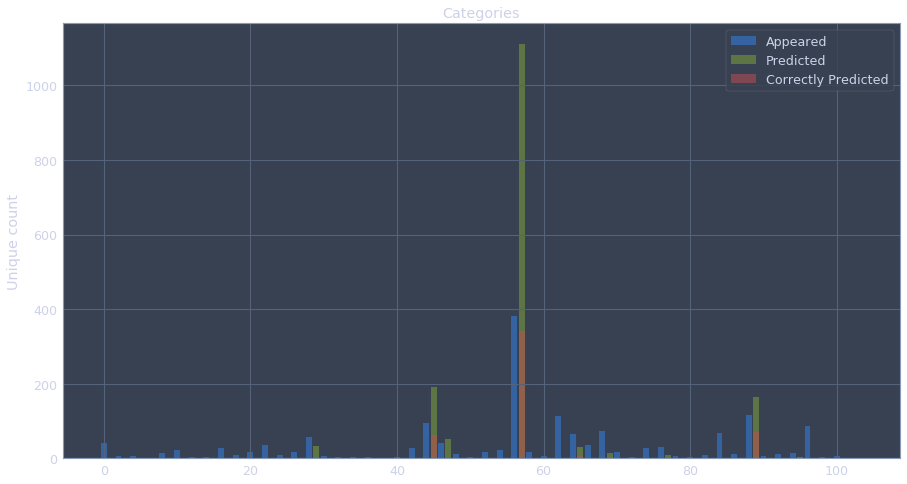

In [257]:
plt.figure(figsize=(15,8))
plt.bar(yPosition, pod, alpha=0.7, label='Appeared')
plt.bar(yPosition, podp, alpha=0.5, label='Predicted')
plt.bar(yPosition, podc, alpha=0.5, label='Correctly Predicted')

plt.ylabel('Unique count')
plt.title('Categories')
plt.legend()
 
plt.show()